## Initial imports and loading data with Pandas

In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline

pd.set_option('mode.chained_assignment', None)

In [255]:
data = pd.read_csv('movie_metadata.csv')

## Taking a look at the data

You need to "run" the two cells below, to do that select the cell and press:  *`Shift-Enter`*

In [256]:
# Run this cell (to do so press Shift-Enter)
data.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,0MM,0MM,0MM,0MM,Joel David Moore,0MM,761MM,Action|Adventure|Fantasy|Sci-Fi,...,0MM,English,USA,PG-13,237MM,0MM,0MM,0MM,0MM,33000
1,Color,Gore Verbinski,0MM,0MM,0MM,0MM,Orlando Bloom,0MM,309MM,Action|Adventure|Fantasy,...,0MM,English,USA,PG-13,300MM,0MM,0MM,0MM,0MM,0
2,Color,Sam Mendes,0MM,0MM,0MM,0MM,Rory Kinnear,0MM,200MM,Action|Adventure|Thriller,...,0MM,English,UK,PG-13,245MM,0MM,0MM,0MM,0MM,85000
3,Color,Christopher Nolan,0MM,0MM,0MM,0MM,Christian Bale,0MM,448MM,Action|Thriller,...,0MM,English,USA,PG-13,250MM,0MM,0MM,0MM,0MM,164000
4,NaN,Doug Walker,nanMM,nanMM,0MM,nanMM,Rob Walker,0MM,nanMM,Documentary,...,nanMM,NaN,NaN,NaN,nanMM,nanMM,0MM,0MM,nanMM,0


In [257]:
data.shape

(5043, 28)

In [258]:
data.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM
mean,0MM,0MM,0MM,0MM,0MM,49MM,0MM,0MM,0MM,0MM,40MM,0MM,0MM,0MM,0MM,0MM
std,0MM,0MM,0MM,0MM,0MM,68MM,0MM,0MM,0MM,0MM,206MM,0MM,0MM,0MM,0MM,0MM
min,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM
25%,0MM,0MM,0MM,0MM,0MM,5MM,0MM,0MM,0MM,0MM,6MM,0MM,0MM,0MM,0MM,0MM
50%,0MM,0MM,0MM,0MM,0MM,26MM,0MM,0MM,0MM,0MM,20MM,0MM,0MM,0MM,0MM,0MM
75%,0MM,0MM,0MM,0MM,0MM,62MM,0MM,0MM,0MM,0MM,45MM,0MM,0MM,0MM,0MM,0MM
max,0MM,0MM,0MM,0MM,1MM,761MM,2MM,1MM,0MM,0MM,12216MM,0MM,0MM,0MM,0MM,0MM


Some key points from this table:
- Avg movie duration is 107.2 minutes
- Avg imdb is 6.44
- Avg number of users reviews is 272

## Cleaning the data

### Dealing with duplicates

In [259]:
print ('Number of duplicates in data: {}'.format(
    sum(data.duplicated(subset=['movie_title', 'title_year'], keep=False))))

Number of duplicates in data: 241


In [260]:
data = data.drop_duplicates(subset=['movie_title', 'title_year'], keep='first').copy()

### Fixing Null and some zero values

In [261]:
# check if data has any null/nan values
data.isnull().values.any()

True

In [262]:
# Check how many values are null in each column
def show_missing_data(data):
    missing_data = data.isnull().sum().reset_index()
    missing_data.columns = ['column_name', 'missing_count']
    missing_data['filling_factor'] = (data.shape[0] - missing_data['missing_count']) / data.shape[0] * 100
    return missing_data.sort_values('filling_factor').reset_index(drop=True)

show_missing_data(data)[:5]

,column_name,missing_count,filling_factor
0,gross,863,0MM
1,budget,485,0MM
2,aspect_ratio,326,0MM
3,content_rating,301,0MM
4,plot_keywords,152,0MM


As we are working with the Gross Box Office, rows without it are of no use. So we will exclude those films that are missing the Gross Box Office.

In [263]:
data.dropna(subset=['gross'], how='all', inplace=True)
show_missing_data(data)[:5]

,column_name,missing_count,filling_factor
0,budget,266,0MM
1,aspect_ratio,104,0MM
2,content_rating,64,0MM
3,plot_keywords,40,0MM
4,actor_3_name,13,0MM


Fill out missing budget datapoints with the median budget for the year it was released.

In [264]:
median_budget_per_year = data.groupby('title_year')['budget'].transform('median')
data['budget'].fillna(median_budget_per_year, inplace=True)

show_missing_data(data)[:5]

,column_name,missing_count,filling_factor
0,aspect_ratio,104,0MM
1,content_rating,64,0MM
2,plot_keywords,40,0MM
3,actor_3_name,13,0MM
4,actor_3_facebook_likes,13,0MM


Fill out the rest of the missing data

In [265]:
data.fillna(0, inplace=True)

Delete all rows where `title_year` is zero

In [266]:
data = data[data['title_year'] != 0]

Budgets are in each country's currency so we are going to use only US movies

In [267]:
data = data[data['country'] == 'USA']

## Understanding the data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1114f5f60>]], dtype=object)

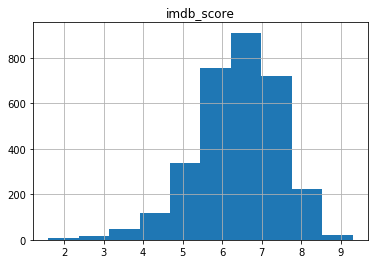

In [268]:
# IMDb rating distribution
data.hist(column='imdb_score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f688048>]], dtype=object)

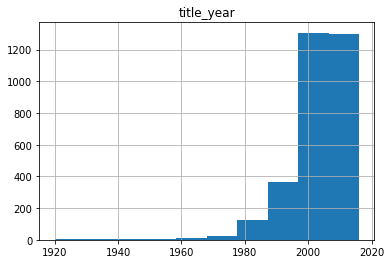

In [269]:
# Movies per year
data.hist(column='title_year')

In [319]:
# Median gross box office per actor
comparison_df = data.groupby('actor_1_name', as_index=False).mean().sort_values('gross', ascending=False)
name_count_key = data['actor_1_name'].value_counts().to_dict()
comparison_df['films'] = comparison_df['actor_1_name'].map(name_count_key)
comparison_df[comparison_df['films'] >= 5][['actor_1_name', 'gross', 'films']][:10]

,actor_1_name,gross,films
1010,Robert Pattinson,193MM,5
541,Jennifer Lawrence,180MM,13
203,Chris Hemsworth,160MM,13
1224,Will Smith,152MM,18
451,Henry Cavill,151MM,5
1172,Tom Hanks,148MM,23
437,Harrison Ford,136MM,25
728,Leonardo DiCaprio,134MM,17
55,Amy Poehler,131MM,8
137,Bradley Cooper,128MM,13


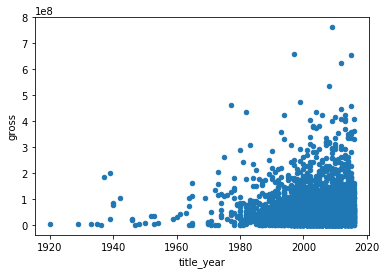

In [270]:
# title year vs gross
data.plot.scatter(x='title_year', y='gross')

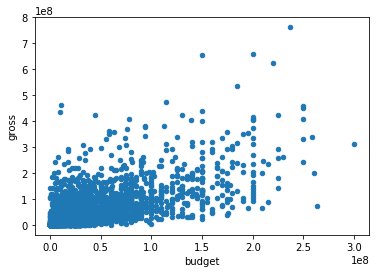

In [271]:
# budget vs gross
data.plot.scatter(x='budget', y='gross')

In [272]:
data.corr()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
num_critic_for_reviews,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,-0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM
duration,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,-0MM,0MM,0MM,0MM,0MM
director_facebook_likes,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,-0MM,0MM,0MM,-0MM,0MM,0MM,0MM,0MM
actor_3_facebook_likes,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM
actor_1_facebook_likes,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM
gross,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,-0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM
num_voted_users,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,-0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM
cast_total_facebook_likes,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM
facenumber_in_poster,-0MM,0MM,-0MM,0MM,0MM,-0MM,-0MM,0MM,0MM,-0MM,-0MM,0MM,0MM,-0MM,0MM,0MM
num_user_for_reviews,0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM,-0MM,0MM,0MM,0MM,0MM,0MM,0MM,0MM


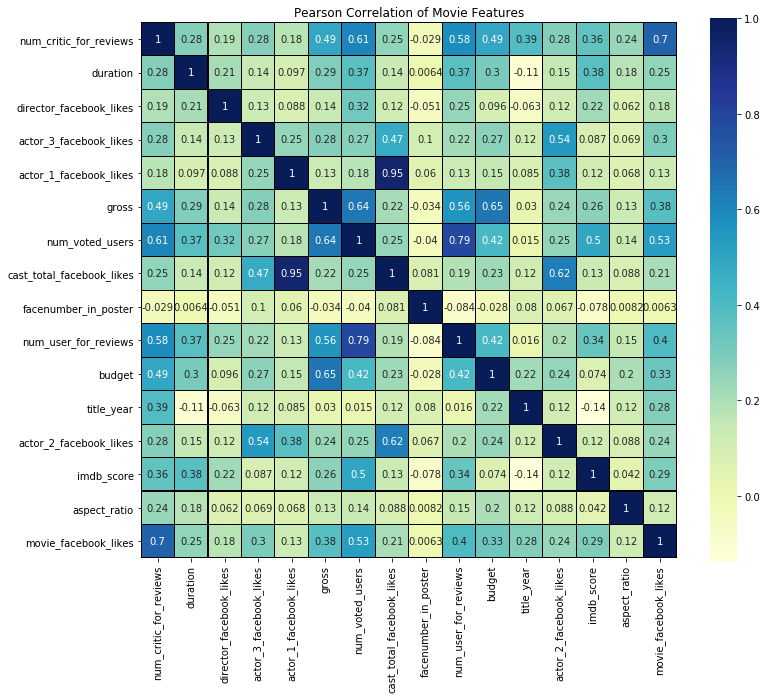

In [273]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
plt.title('Pearson Correlation of Movie Features')

# Draw the heatmap using seaborn
sns.heatmap(data.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True)

As we can see from the heatmap, there are regions (features) where we can see quite positive linear correlations amongst each other, given the darker shade of the colours - top left-hand corner and bottom right quarter. This is a good sign as it means we may be able to find linearly correlated features for which we can perform PCA projections on.

In [274]:
data.corr()['gross'].sort_values(ascending=False)

gross                        0MM
budget                       0MM
num_voted_users              0MM
num_user_for_reviews         0MM
num_critic_for_reviews       0MM
movie_facebook_likes         0MM
duration                     0MM
actor_3_facebook_likes       0MM
imdb_score                   0MM
actor_2_facebook_likes       0MM
cast_total_facebook_likes    0MM
director_facebook_likes      0MM
actor_1_facebook_likes       0MM
aspect_ratio                 0MM
title_year                   0MM
facenumber_in_poster        -0MM
Name: gross, dtype: float64

The gross box office correlates strongly with num_voted_users, num_users_for_reviews and movie_facebook_likes. But some of those features are also highly correlated among each other (as you can see in the heatmap above).

## Gross Box Office Prediction

### Getting numerical data

In [275]:
numerical_columns = data.dtypes[data.dtypes != 'object'].index
numerical_data = data[numerical_columns]

# we drop aspect_ratio, as it doesn't provide any useful info
numerical_data.drop('aspect_ratio', axis=1, inplace=True)
numerical_data.head(2)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,0MM,0MM,0MM,0MM,0MM,761MM,886204,4834,0MM,0MM,237MM,0MM,0MM,0MM,33000
1,0MM,0MM,0MM,0MM,0MM,309MM,471220,48350,0MM,0MM,300MM,0MM,0MM,0MM,0


### Preparing train and test datasets

In [276]:
train, test = train_test_split(numerical_data, test_size=0.2)
target_train = train.pop('gross')
target_test = test.pop('gross')

In [277]:
print('Train data: {} / {} = {}'.format(len(train), len(numerical_data), float(len(train)/len(numerical_data))))
print('Test data: {} / {} = {}'.format(len(test), len(numerical_data), float(len(test)/len(numerical_data))))

Train data: 2523 / 3154 = 0.7999365884590995
Test data: 631 / 3154 = 0.20006341154090043


### Linear Regression

In [278]:
model = LinearRegression()
model.fit(train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [279]:
prediction = model.predict(test)

Mean squared error: 2092850258364196.00
Variance score: 0.57


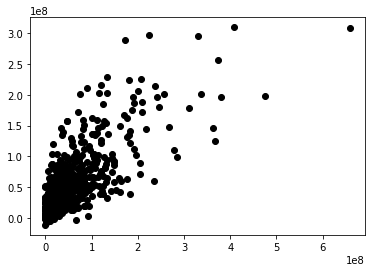

In [280]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(target_test, prediction))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(target_test, prediction))

# Plot outputs
plt.scatter(target_test, prediction,  color='black')
# plt.plot(test, prediction, color='blue', linewidth=3)


plt.show()

### Random Forest

In [281]:
forest = RandomForestRegressor(
    max_depth=25,
    min_samples_split=15,
    n_estimators=1000,
    random_state=1)

forest.fit(train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=15,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [282]:
forest.feature_importances_

array([ 0.03096896,  0.0255039 ,  0.01372093,  0.01241161,  0.01203248,
        0.55398537,  0.01626694,  0.0037742 ,  0.03256502,  0.22040005,
        0.03298063,  0.01266119,  0.01791057,  0.01481815])

In [283]:
forest_prediction = forest.predict(test)

Mean squared error: 1771456081319270.75
Variance score: 0.63


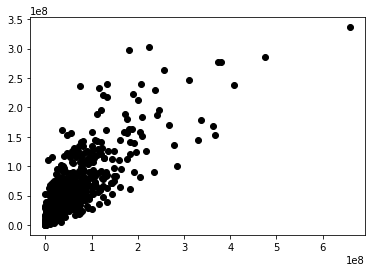

In [284]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(target_test, forest_prediction))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(target_test, forest_prediction))

# Plot outputs
plt.scatter(target_test, forest_prediction,  color='black')
# plt.plot(test, prediction, color='blue', linewidth=3)


plt.show()

## Dropping post-fact data

There are post-fact variables in our data set making the prediction more accurate. Things like `num_voted_users` and `num_user_for_reviews` are after the fact metrics, so probably not as useful for prediction.

In [285]:
train.head(2)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
4201,0MM,0MM,0MM,0MM,0MM,91,1064,0MM,0MM,2MM,0MM,0MM,0MM,144
4677,0MM,0MM,0MM,0MM,0MM,101287,2714,0MM,0MM,1MM,0MM,0MM,0MM,31000


In [286]:
train.drop(['num_critic_for_reviews', 'num_voted_users', 'num_user_for_reviews', 'imdb_score', 'movie_facebook_likes'], axis=1, inplace=True)
test.drop(['num_critic_for_reviews', 'num_voted_users', 'num_user_for_reviews', 'imdb_score', 'movie_facebook_likes'], axis=1, inplace=True)
train.head(2)

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,budget,title_year,actor_2_facebook_likes
4201,0MM,0MM,0MM,0MM,1064,0MM,2MM,0MM,0MM
4677,0MM,0MM,0MM,0MM,2714,0MM,1MM,0MM,0MM


In [287]:
pre_data_forest = RandomForestRegressor(
    max_depth=25,
    min_samples_split=15,
    n_estimators=1000,
    random_state=1)

pre_data_forest.fit(train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=15,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [288]:
second_prediction = pre_data_forest.predict(test)

Mean squared error: 2957901233504547.50
Variance score: 0.39


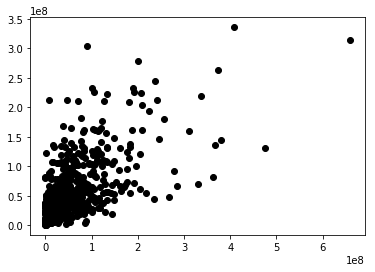

In [289]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(target_test, second_prediction))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(target_test, second_prediction))

# Plot outputs
plt.scatter(target_test, second_prediction,  color='black')
# plt.plot(test, prediction, color='blue', linewidth=3)


plt.show()

## Over/Under performing movies

In [290]:
numerical_data_target = numerical_data.pop('gross')
all_data_prediction = forest.predict(numerical_data)

In [324]:
performance = numerical_data_target - all_data_prediction

data["prediction"] = all_data_prediction
data["performance_diff"] = performance
data["performance_diff_percent"] = performance / numerical_data_target * 100
data["performance_diff_percent"] = data["performance_diff_percent"].map('{:,.2f}%'.format)

performance_repr = data.sort_values(['performance_diff'], ascending=False)[
    ['movie_title', 'gross', 'prediction', 'performance_diff', 'performance_diff_percent']]

pd.set_option('display.float_format', lambda x: '%.0fMM' % (x/1000000))

In [325]:
performance_repr[:5]

,movie_title,gross,prediction,performance_diff,performance_diff_percent
26,Titanic,659MM,336MM,322MM,48.93%
0,Avatar,761MM,486MM,274MM,36.05%
29,Jurassic World,652MM,383MM,269MM,41.30%
3024,Star Wars: Episode IV - A New Hope,461MM,221MM,239MM,51.96%
3080,E.T. the Extra-Terrestrial,435MM,198MM,237MM,54.55%


In [329]:
performance_repr[:-6:-1]

,movie_title,gross,prediction,performance_diff,performance_diff_percent
573,Braveheart,76MM,236MM,-160MM,-212.00%
96,Interstellar,188MM,337MM,-149MM,-79.09%
525,Children of Men,35MM,161MM,-126MM,-357.07%
130,Thor,181MM,298MM,-117MM,-64.86%
52,Pacific Rim,102MM,218MM,-116MM,-113.83%
